# Visualising taxa abundance

In [5]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(egg)
require(foreach)
require(doParallel)
registerDoParallel(cores=8)

## Functions for data parsing

In [6]:
load_data <- function(file_path) {
    df <- fread(file_path) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.") %>%
        as_tibble()
    return(df)
}


get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


otu_to_RA <- function(df) {
    mat <- as.matrix(df[, colnames(df) != "npm_research_id"])
    RA_df <- as.data.frame(mat / rowSums(mat))
    RA_df <- add_column(RA_df, df$npm_research_id, .before = 1)
    colnames(RA_df)[1] <- "npm_research_id"
    
    return(RA_df)
}

get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


In [7]:
species_df <- load_data(str_glue("data/temp_files_9999/07_abundance_matrix/abundance_matrix.subset_9999.S.tsv"))
to_retain <- read.csv("data/samples_above_100_microbial_reads.txt")$npm_research_id
species_filt <- species_df %>% filter(npm_research_id %in% to_retain)

meta <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv")
meta_cols <- get_meta_cols(meta)

### Remove low read samples

#### Get total no. of assigned microbial reads

In [8]:
micro_df <- species_df %>% select(-npm_research_id, -unclassified, -"Homo sapiens")
rowsum_df <- tibble(npm_research_id = species_df$npm_research_id, rowsums = rowSums(micro_df))
rowsum_df <- rowsum_df %>%
    left_join(meta) %>%
    mutate(microbe_frac = (rowsums * 2) / raw_total_sequences, .before = 2)

Joining, by = "npm_research_id"



In [9]:
to_keep <- rowsum_df %>% 
    filter(rowsums >= 100) %>%
    select(npm_research_id)
fwrite(to_keep, "data/samples_above_100_microbial_reads.txt")

species_filt <- species_df %>% filter(npm_research_id %in% to_keep$npm_research_id)

### Prevalence

In [10]:
otu_to_PA <- function(df, read_threshold) {
    prev_read <- df %>%
        select(-"Homo sapiens", -unclassified) %>%
        column_to_rownames("npm_research_id")
    
    prev_read[prev_read <= read_threshold] <- 0
    prev_read[prev_read > read_threshold] <- 1

    return(prev_read)
}


RA_to_PA <- function(RA_df, PA_threshold) {
    prev_RA <- RA_df %>% column_to_rownames("npm_research_id")
    prev_RA[prev_RA <= PA_threshold] <- 0
    prev_RA[prev_RA > PA_threshold] <- 1
    
    return(prev_RA)
}


filter_taxa_by_presence <- function(prev_df, presence_t) {
    taxa_counts <- apply(prev_df, 2, sum)
    to_keep <- names(taxa_counts)[taxa_counts > presence_t]
    return(prev_df %>% select(all_of(to_keep)))
}

#### Read count

In [11]:
prev_read <- otu_to_PA(species_filt, 0)
prev_read_10 <- otu_to_PA(species_filt, 10)
prev_read_df <- tibble(npm_research_id = rownames(prev_read), n_assigned = rowSums(prev_read))
prev_read_df_10 <- tibble(npm_research_id = rownames(prev_read_10), n_assigned = rowSums(prev_read_10))

read_plt <- prev_read_df %>%
    arrange(desc(n_assigned)) %>%
    ggplot(aes(x = n_assigned)) +
    geom_histogram() +
    labs(x = "No. of taxa / sample (reads > 0)", y = "No. of samples")

read_plt_10 <- prev_read_df_10 %>%
    arrange(desc(n_assigned)) %>%
    ggplot(aes(x = n_assigned)) +
    geom_histogram() +
    labs(x = "No. of taxa / sample (reads > 10)", y = "No. of samples")

#### RA

In [12]:
species_RA <- otu_to_RA(species_filt %>% select(-"Homo sapiens", -unclassified))
prev_RA <- RA_to_PA(species_RA, 0.01)
prev_RA_df <- tibble(npm_research_id = rownames(prev_RA), n_assigned = rowSums(prev_RA))

RA_plt <- prev_RA_df %>%
    arrange(desc(n_assigned)) %>%
    ggplot(aes(x = n_assigned)) +
    geom_histogram() +
    labs(x = "No. of taxa / sample (RA > 0.01)", y = "No. of samples")

#### RA + reads

In [13]:
# Reads
prev_RA_read <- as.data.frame(prev_read_10 & prev_RA)
prev_RA_read_df <- tibble(npm_research_id = rownames(prev_RA_read), n_assigned = rowSums(prev_RA_read))
prev_RA_read

RA_read_plt <- prev_RA_read_df %>%
    arrange(desc(n_assigned)) %>%
    ggplot(aes(x = n_assigned)) +
    geom_histogram(bins = 20) +
    labs(x = "No. of taxa / sample (RA > 0.01 & reads > 10)", y = "No. of samples")

,Paraburkholderia fungorum,Paraburkholderia xenovorans,Paraburkholderia hospita,Ralstonia pickettii,Ralstonia insidiosa,Ralstonia mannitolilytica,Ralstonia solanacearum,Burkholderia cepacia,Burkholderia sp. LA-2-3-30-S1-D2,Burkholderia metallica,⋯,Mycobacterium virus Che12,Grapevine Cabernet Sauvignon reovirus,Delftia phage IME-DE1,Fowlpox virus,Bacillus sp. Pc3,Agrotis segetum nucleopolyhedrovirus B,Vibrio phage 11895-B1,Mycobacterium phage Milly,Cacao swollen shoot Togo A virus,Streptomyces phage phiSASD1
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
WHB669,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB8678,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHH7080,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB4818,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB9470,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB4637,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB3974,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB7065,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB8830,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


#### No. of species present per sample

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Saving 6.67 x 6.67 in image



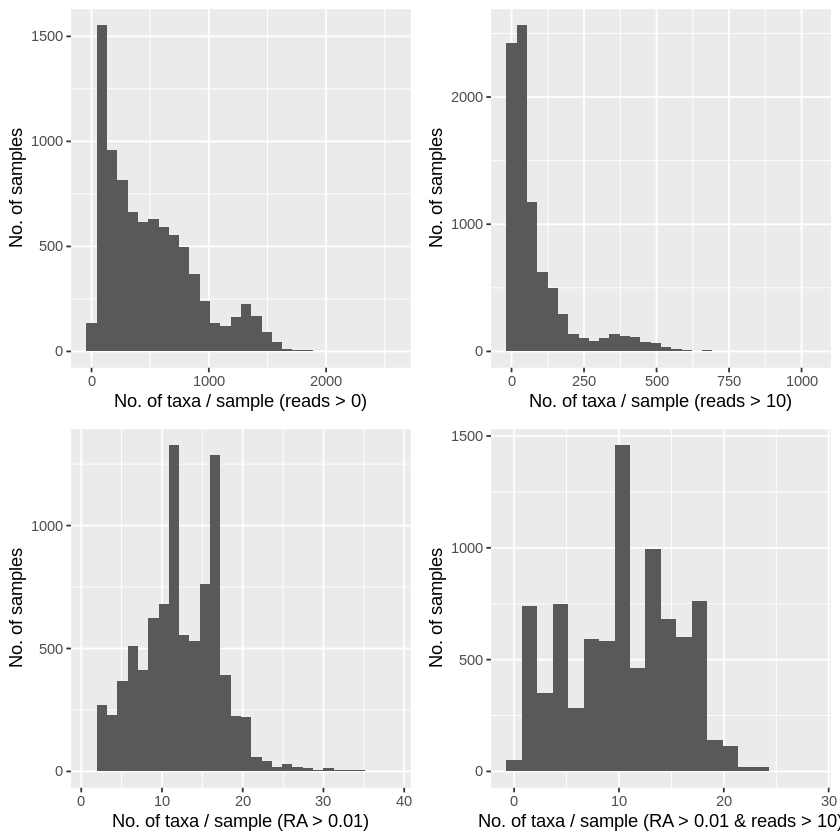

In [14]:
combined <- ggpubr::ggarrange(read_plt, read_plt_10, RA_plt, RA_read_plt)

combined

ggsave("results/decontamination/presence_absence_threshold_multiplot.png", dpi = 300)

#### Overall prevalence

In [15]:
prev_RA_read <- filter_taxa_by_presence(prev_RA_read, 0)

In [16]:
prev_overall <- prev_RA_read %>%
    pivot_longer(everything(), names_to = "taxa", values_to = "presence") %>%
    group_by(taxa) %>%
    summarise(prevalence = sum(presence) / nrow(prev_RA_read)) %>%
    mutate(bin = case_when(prevalence == 0 ~ "0",
                           prevalence > 0 & prevalence <= 0.05 ~ "0-0.05",
                           prevalence > 0.05 & prevalence <= 0.25 ~ "0.05-0.25",
                           prevalence > 0.25 & prevalence <= 0.5 ~ "0.25-0.5",
                           prevalence > 0.5 & prevalence <= 0.75 ~ "0.5-0.75",
                           prevalence > 0.75 ~ "0.75-1")) %>%
    mutate(bin = factor(bin, levels = c("0", "0-0.05", "0.05-0.25", "0.25-0.5", "0.5-0.75", "0.75-1"))) %>%
    arrange(desc(prevalence))

prev_overall

taxa,prevalence,bin
<chr>,<dbl>,<fct>
Bradyrhizobiaceae bacterium SG-6C,0.3076477,0.25-0.5
Rhodopseudomonas palustris,0.3066032,0.25-0.5
Bradyrhizobium sp. SK17,0.2713241,0.25-0.5
Alcaligenes faecalis,0.2620402,0.25-0.5
Methylobacterium currus,0.2561216,0.25-0.5
Sphingomonas sp. LM7,0.2541488,0.25-0.5
Sphingomonas sp. Cra20,0.2477660,0.05-0.25
Sphingomonas hengshuiensis,0.2466055,0.05-0.25
Sphingomonas koreensis,0.2310549,0.05-0.25


In [17]:
max(prev_overall$prevalence)

[1] 0.3076477

Saving 6.67 x 6.67 in image



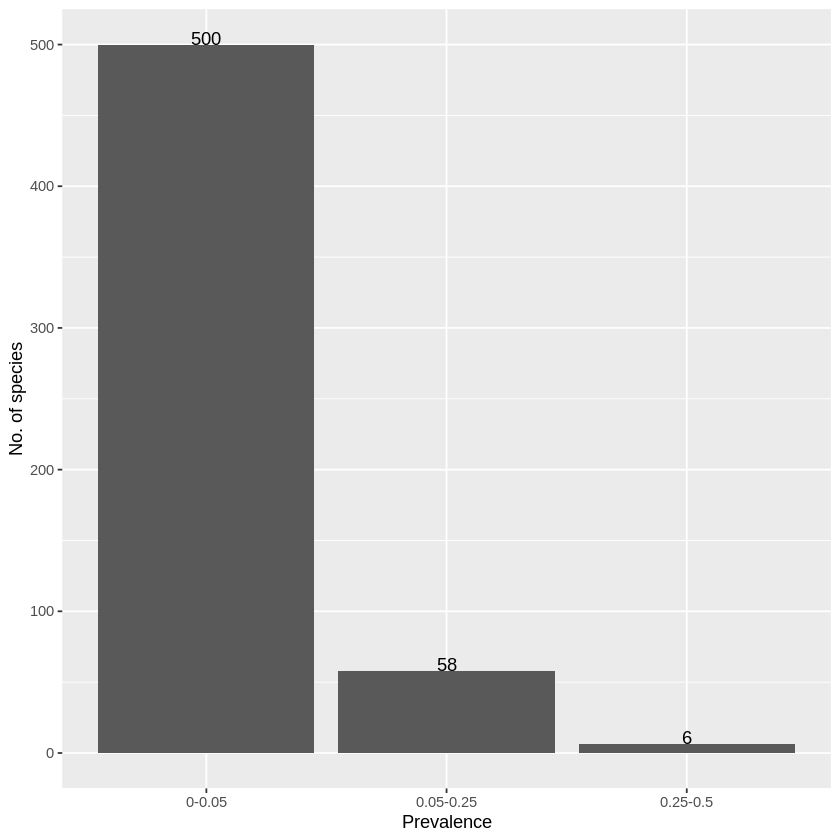

In [18]:
prev_overall %>% 
    ggplot(aes(x = bin, y = ..count..)) + 
    geom_bar() +
    stat_count(aes(y = ..count.., label = ..count..), geom = "text",vjust = 0) +
    labs(x = "Prevalence", y = "No. of species")

ggsave(str_glue("results/decontamination/RA_0.01_read_10_overall_prevalence.png"), dpi = 300)

In [ ]:
prev_plots <- foreach(read_t = c(0, 1, 5, 10, 50, 100, 500, 1000)) %dopar% {
    temp_prev <- otu_to_prev(species_df, read_t)
    
    prev_overall <- temp_prev %>%
        pivot_longer(!npm_research_id, names_to = "taxa", values_to = "presence") %>%
        group_by(taxa) %>%
        summarise(prevalence = sum(presence) / nrow(species_prev)) %>% 
        mutate(bin = case_when(prevalence == 0 ~ "0",
                               prevalence > 0 & prevalence <= 0.05 ~ "0-5",
                               prevalence > 0.05 & prevalence <= 0.25 ~ "5-25",
                               prevalence > 0.25 & prevalence <= 0.5 ~ "25-50",
                               prevalence > 0.5 & prevalence <= 0.75 ~ "50-75",
                               prevalence > 0.75 ~ "75-100")) %>%
        mutate(bin = factor(bin, levels = c("0", "0-5", "5-25", "25-50", "50-75", "75-100")))
    
    prev_overall %>% 
        ggplot(aes(x = bin)) + 
        geom_histogram(stat="count") +
        stat_count(aes(y=..count..,label=..count..),geom = "text",vjust = 0) +
        labs(title = str_glue("PA_threshold = {read_t}"), x = "Overall Prevalence (%)", y = "No. of taxa")
}


In [ ]:
combined <- egg::ggarrange(plots = prev_plots)
ggsave(str_glue("results/decontamination/PA_threshold_taxa_prevalence.png"), plot = combined, dpi = 300, width = 10, height = 10)

#### Batch prevalence

In [76]:
taxa <- colnames(species_prev)
taxa <- taxa[taxa != "npm_research_id"]

In [89]:
meta_cols

[1] "site_supplying_sample"                              
[2] "extraction_kit"                                     
[3] "instrument_id"                                      
[4] "hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot"    
[5] "hiseq_xtm_sbs_kit_300_cycles_v2__box_2_of_2__lot"   
[6] "hiseq_xtm_pe_cluster_kit_cbottm_v2__box_1_of_2__lot"
[7] "hiseq_xtm_pe_cluster_kit_cbottm_v2__box_2_of_2__lot"
[8] "hiseq_xtm_flow_cell_v2_5_lot"

In [134]:
col <- "hiseq_xtm_sbs_kit_300_cycles_v2__box_2_of_2__lot"

batch_prev <- species_prev %>% 
    left_join(meta) %>%
    select(all_of(c(taxa, col))) %>%
    pivot_longer(!all_of(col), names_to = "taxa", values_to = "presence") %>%
    group_by(taxa, get(col)) %>%
    summarise(prevalence = sum(presence) / n()) %>%
    rename(batch = "get(col)") %>%
    arrange(desc(prevalence))

Joining, by = "npm_research_id"

`summarise()` has grouped output by 'taxa'. You can override using the `.groups` argument.



In [135]:
prev_overall %>% arrange(desc(prevalence))

taxa,prevalence,bin
<chr>,<dbl>,<fct>
Rhodopseudomonas palustris,0.2949953,0.25-0.5
Bradyrhizobiaceae bacterium SG-6C,0.2801782,0.25-0.5
Bradyrhizobium sp. SK17,0.2753083,0.25-0.5
Sphingomonas sp. LM7,0.2414258,0.05-0.25
Alcaligenes faecalis,0.2375920,0.05-0.25
Sphingomonas sp. Cra20,0.2351052,0.05-0.25
Methylobacterium currus,0.2347943,0.05-0.25
Sphingomonas hengshuiensis,0.2343799,0.05-0.25
Sphingomonas koreensis,0.2152109,0.05-0.25


In [137]:
batch_prev %>% 
    filter(taxa == "Rhodopseudomonas palustris") %>%
    summarise(n = n_distinct(batch))

taxa,n
<chr>,<int>
Rhodopseudomonas palustris,34


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



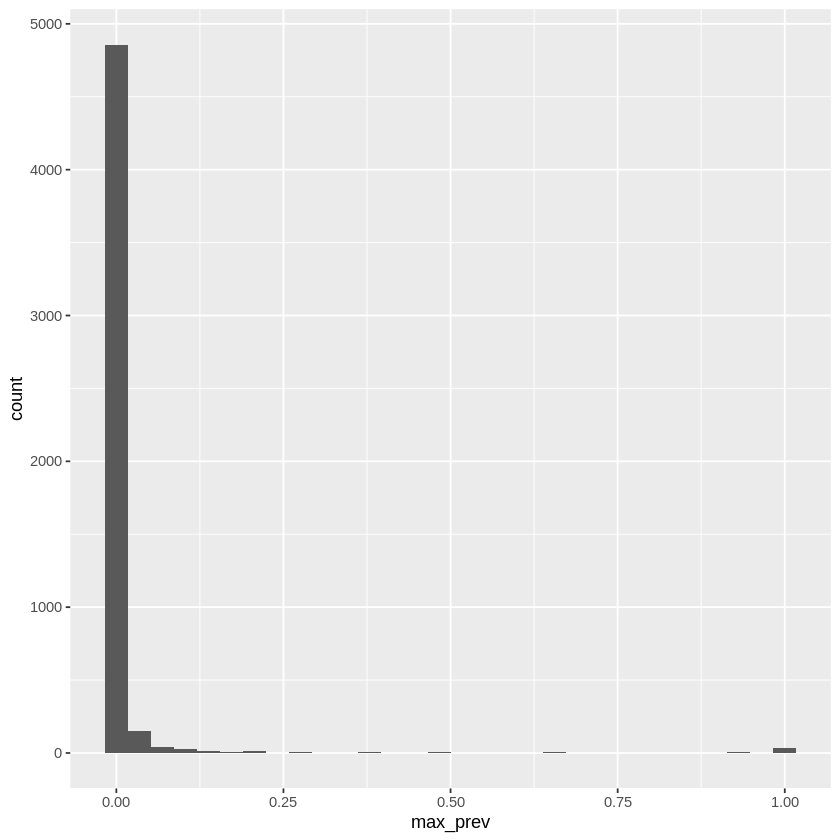

In [166]:
batch_prev %>% 
    group_by(taxa) %>%
    summarise(max_prev = max(prevalence)) %>%
    ggplot(aes(x = max_prev)) +
    geom_histogram()


In [14]:
batch_prev %>%
    filter(taxa == "Moraxella osloensis", batch != "Unknown") %>%
    ggplot(aes(x = batch, y = prevalence)) +
    geom_bar(stat = "identity") +
    labs(x = col, y = "Batch prevalence") +
    ylim(0, 1) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

ERROR: Error in filter(., taxa == "Moraxella osloensis", batch != "Unknown"): object 'batch_prev' not found


#### Retrieve 20 species for each prevalence class

In [ ]:
morsels <- foreach (bin_name = c("0-5", "5-25", "25-50", "50-75")) %do% {
    prev_bin <- prev_overall %>%
        filter(bin == bin_name)
    
    if (nrow(prev_bin) >= 20) {
        prev_bin %>% sample_n(20, replace = F)
    } else {
        prev_bin %>% sample_n(nrow(prev_bin), replace = F)
    }
}

prev_bin_df <- bind_rows(morsels)
selected_taxa <- prev_bin_df$taxa

#### Per-batch prevalence of positive controls

In [ ]:
pos_taxa <- read.csv("data/reported_controls/damgaard_2015_positive.txt")$positive_controls
pos_taxa <- pos_taxa[pos_taxa %in% colnames(species_prev)]

In [ ]:
taxon_name <- gsub(" ", "_", taxon)
taxon_name <- gsub("\\.", "", taxon_name)
taxon_name

In [ ]:
taxon <- "Streptococcus pneumoniae"
taxon <- "Moraxella osloensis"
# taxon <- "Burkholderia cepacia"
# taxon <- "Actinobacillus pleuropneumoniae"
# taxon <- "Ralstonia insidiosa"
# column <- "extraction_kit"
column <- "hiseq_xtm_flow_cell_v2_5_lot"

prev_stats <- species_prev %>% 
            left_join(meta, by = "npm_research_id") %>%
            group_by_at(c(column)) %>%
            summarise(sum = sum(get(taxon))) %>%
            mutate(batch_n = as.vector(table(meta[, column])),
                   prevalence = sum / as.vector(table(meta[, column])))

prev_stats %>%
    filter(get(column) != "Unknown") %>%
    ggplot(aes(x = get(column), y = prevalence * 100)) +
    geom_bar(stat = "identity", fill = "#6b3074") +
    ylim(-3, 100) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x = column, y = "Prevalence (%)", title = taxon) +
    ylim(-3, 100) +
    geom_text(aes(x = get(column), y = -3, label = batch_n), angle = 45)

taxon_name <- gsub(" ", "_", taxon)
taxon_name <- gsub("\\.", "", taxon_name)
ggsave(str_glue("results/decontamination/diff_prev_V2/{taxon_name}.prevalence.png"), dpi = 300)

#### For selected taxa

In [ ]:
for (read_t in c(0, 5, 10, 20, 50, 100)) {
    species_prev <- species_df %>% select(-npm_research_id, -"Homo sapiens", -unclassified)
    species_prev[species_prev <= read_t] <- 0
    species_prev[species_prev > read_t] <- 1
    species_prev <- species_prev %>% add_column(npm_research_id = species_df$npm_research_id, .before = 1)

    dir.create(str_glue("results/decontamination/diff_prev/diff_prev_sanity_check/selected_taxa/read_t{read_t}/"))

    for (column in meta_cols) {
        plot_list <- foreach(taxon = selected_taxa) %do% {
            prev_stats <- species_prev %>% 
                        left_join(meta, by = "npm_research_id") %>%
                        group_by_at(c(column)) %>%
                        summarise(sum = sum(get(taxon))) %>%
                        mutate(batch_n = as.vector(table(meta[, column])),
                               prevalence = sum / as.vector(table(meta[, column])))

            # prev_stats
            tmp_plt <- prev_stats %>%
                filter(get(column) != "Unknown") %>%
                ggplot(aes(x = get(column), y = prevalence * 100)) +
                ylim(-3, 100) +
                geom_text(aes(x = get(column), y = -3, label = batch_n), angle = 45) +
                theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                labs(x = column, y = "Prevalence (%)", title = taxon)
            
            bin_level <- prev_bin_df[prev_bin_df$taxa == taxon, ]$bin
            
            if (bin_level == "0-5") {
                tmp_plt + geom_bar(stat = "identity", fill = "#98c1d9")
            } else if (bin_level == "5-25") {
                tmp_plt + geom_bar(stat = "identity", fill = "#3d5a80")
            } else if (bin_level == "25-50") {
                tmp_plt + geom_bar(stat = "identity", fill = "#6b3074")
            } else {
                tmp_plt + geom_bar(stat = "identity", fill = "#ee6c4d")
            }
        }
        
        combined <- egg::ggarrange(plots = plot_list)

        ggsave(str_glue("results/decontamination/diff_prev/diff_prev_sanity_check/selected_taxa/read_t{read_t}/prevalence.{column}.read_t{read_t}.png"), plot = combined, width = 40, height = 40)
    }
}

#### For positive controls

In [ ]:
# for (read_t in c(0, 1, 2, 4, 5, 10, 20, 50, 100, 500, 1000)) {
#     # read_t <- 10
#     species_prev <- species_df %>% select(-npm_research_id, -"Homo sapiens", -unclassified)
#     species_prev[species_prev <= read_t] <- 0
#     species_prev[species_prev > read_t] <- 1
#     species_prev <- species_prev %>% add_column(npm_research_id = species_df$npm_research_id, .before = 1)

#     dir.create(str_glue("results/decontamination/diff_prev/diff_prev_sanity_check/pos_controls/read_t{read_t}/"))

#     for (column in meta_cols) {
#         plot_list <- foreach(taxon = pos_taxa) %do% {
#             prev_stats <- species_prev %>% 
#                         left_join(meta, by = "npm_research_id") %>%
#                         group_by_at(c(column)) %>%
#                         summarise(sum = sum(get(taxon))) %>%
#                         mutate(batch_n = as.vector(table(meta[, column])),
#                                prevalence = sum / as.vector(table(meta[, column])))

#             # prev_stats
#             prev_stats %>%
#                 filter(get(column) != "Unknown") %>%
#                 ggplot(aes(x = get(column), y = prevalence * 100)) +
#                 geom_bar(stat = "identity") +
#                 ylim(-3, 100) +
#                 geom_text(aes(x = get(column), y = -3, label = batch_n), angle = 45) +
#                 theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
#                 labs(x = column, y = "Prevalence (%)", title = taxon)
#         }

#         combined <- egg::ggarrange(plots = plot_list)

#         ggsave(str_glue("results/decontamination/diff_prev/diff_prev_sanity_check/pos_controls/read_t{read_t}/prevalence.{column}.read_t{read_t}.png"), plot = combined, width = 40, height = 40)
#     }
# }

In [ ]:
dawdawdw

#### Overall prevalence

In [ ]:
prev_stats <- apply(species_prev[, 2:ncol(species_prev)], 2, sum) / nrow(species_df)
prev_df <- data.frame(taxa = names(prev_stats), prevalence = as.vector(prev_stats))
prev_df %>% arrange(desc(prevalence))

In [ ]:
all_species <- colnames(species_df %>% select(-npm_research_id, -"Homo sapiens", -unclassified))
to_include <- prev_df$taxa[prev_df$prevalence != 0]
all_species <- all_species[all_species %in% to_include]
print(length(all_species))

In [ ]:
all_species <- colnames(species_df %>% select(-npm_research_id, -"Homo sapiens", -unclassified))
any(grepl("Propionibacterium", all_species))
all_species[grepl("Cutibacterium", all_species)]

In [ ]:
test <- fread("results/decontamination/max_batch_prevalence.kit.site.instrument.read_t100.csv")
test %>% 
    arrange(desc(max_batch_prev)) %>%
    filter(max_batch_prev > 0.7)

In [ ]:
# col <- "site_supplying_sample"
# taxon <- "Bradyrhizobium sp. SK17"
system.time({
    morsels <- foreach(taxon = all_species) %dopar% {
        crumbs <- foreach (col = meta_cols) %do% {
            max_batch_prev <- species_prev %>% 
                left_join(meta) %>% 
                filter(get(col) != "Unknown") %>%
                select(all_of(c(taxon, col))) %>%
                group_by(get(col)) %>%
                summarise(prevalence = sum(get(taxon)) / n())
            max_batch_prev <- max(max_batch_prev$prevalence)

            tibble(meta_col = col, max_batch_prev = max_batch_prev)
        }


        crumb <- bind_rows(crumbs)
        max_batch_prev <- max(crumb$max_batch_prev)

        tibble(meta_col = taxon, max_batch_prev = max_batch_prev)
    }

    max_prev_df <- bind_rows(morsels)

})

fwrite(max_prev_df, str_glue("results/decontamination/max_batch_prevalence.kit.site.instrument.read_t{read_t}.csv"))

In [ ]:
fwrite(max_prev_df, str_glue("results/decontamination/max_batch_prevalence.kit.site.instrument.read_t{read_t}.csv"))

### Retrieve samples for simulations

In [ ]:
calc <- meta %>%
    summarise(min = min(raw_total_sequences), 
              median = median(raw_total_sequences),
              max = max(raw_total_sequences),
              n = n_distinct(npm_research_id))

calc 

X <- as.matrix(species_df[, 2:ncol(species_df)])
y <- species_df$npm_research_id

rowsum_df <- tibble(npm_research_id = y, rowsums = rowSums(X)) %>%
    left_join(meta) %>%
    mutate(frac_microb = rowsums / raw_total_sequences) 

rowsum_df %>%
    summarise(min = min(rowsums), 
              median = median(rowsums),
              max = max(rowsums),
              n = n_distinct(npm_research_id))

rowsum_df %>%
    summarise(min = min(frac_microb), 
              median = median(frac_microb),
              max = max(frac_microb),
              n = n_distinct(npm_research_id))

In [ ]:
nc <- read.csv("results/decontamination/correlation_decontamination/nc.diff_prev.diff_abn.l15h85.corr_t0.1.S.n9999.txt")$non_contaminant_taxon


In [ ]:
test <- species_df %>%
    filter(get("Human betaherpesvirus 6A") > 8700) %>%
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "read_count") %>%
    arrange(desc(read_count)) %>%
    filter(read_count > 0)
test$taxa[test$taxa %in% nc]

In [ ]:
read.csv("data/reported_controls/damgaard_2015_positive.txt")

In [ ]:
max(species_df$`Staphylococcus aureus`)

In [ ]:
species_df %>% 
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "read_count") %>%
    group_by(taxa) %>%
    summarise(max_count = max(read_count)) %>%
    filter(grepl("torque teno virus 1|herpes", taxa, ignore.case = T)) %>%
    arrange(desc(max_count)) %>%
    head()

### Find no. of taxa in samples with human viruses

In [ ]:
species_df1 %>% 
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "read_count") %>%
    group_by(taxa) %>%
    summarise(max_count = max(read_count)) %>%
    filter(grepl("torque teno|herpes", taxa, ignore.case = T)) %>%
    arrange(desc(max_count)) %>%
    head()

In [ ]:
species_prev100 %>% 
    column_to_rownames("npm_research_id") %>%
    select_if(grepl("Torque teno|Human", names(.))) %>% colnames()

In [ ]:
species_prev100 <- otu_to_prev(species_df, 100)
with_virus <- species_prev100 %>% 
    column_to_rownames("npm_research_id") %>%
    select_if(grepl("Torque teno|Human", names(.))) %>% 
    mutate(rowsums = rowSums(.)) %>%
    filter(rowsums > 0) %>%
    rownames()

In [ ]:
species_prev100 %>% 
    filter(npm_research_id %in% with_virus) %>%
    column_to_rownames("npm_research_id") %>%
    mutate(rowsums = rowSums(.)) %>%
    select(rowsums) %>% 
    summarise(median = median(rowsums))


## Distribution of microbial reads per sample

In [ ]:
read_counts <- apply(genus_df %>% select(-npm_research_id, -unclassified, -Homo), 1, sum)

genus_reads <- genus_df %>% 
    select(-unclassified, -Homo) %>%
    mutate(total = rowSums(across(where(is.numeric))))
    
genus_reads %>% 
    ggplot(aes(x = log(total, base = 10))) +
    geom_histogram(bins = 50) +
    labs(x = "lg(microbial reads)", y = "No. of samples")

In [ ]:
load_data(str_glue("data/temp_files_9999/07_abundance_matrix/abundance_matrix.subset_9999.S.tsv")) %>%
    column_to_rownames("npm_research_id") %>%
    select(-"Homo sapiens", -unclassified) %>%
    mutate(rowsums = rowSums(.)) %>%
    ggplot(aes(x = log(rowsums, base = 10))) +
    geom_histogram(bins = 100) +
    labs(x = "Log(classified read counts, base = 10)", y = "No. of samples")

## Choosing microbial read per sample threshold

In [ ]:
n_left <- c()
t_vec <- seq(1, 1000, 10)

morsels <- foreach (t = t_vec) %do% {
    tmp <- genus_reads %>% 
        filter(total > t)
    
    morsel <- tibble(t = t, n_left = nrow(tmp))
    return(morsel)
}

head(bind_rows(morsels))


In [ ]:
bind_rows(morsels) %>% 
    ggplot(aes(x = t, y = n_left)) +
    geom_line() +
    labs(x = "Read count threshold", y = "No. of samples retained")

In [ ]:
genus_reads %>%
    left_join(meta) %>%
    ggplot(aes(x = site_supplying_sample, y = log(total, base = 10))) +
    geom_boxplot()

In [ ]:
# t <- 500
t <- quantile(genus_reads$total, 0.1)[[1]]
to_retain <- genus_reads %>% 
    filter(total > t) %>%
    select(npm_research_id)

nrow(to_retain)
fwrite(to_retain, str_glue("data/samples_above_{t}_reads.txt"))

In [ ]:
before <- genus_reads %>%
    left_join(meta) %>%
    ggplot(aes(x = site_supplying_sample, y = log(total, base = 10))) +
    geom_boxplot()

after <- genus_reads %>%
    left_join(meta) %>%
    filter(npm_research_id %in% to_retain$npm_research_id) %>%
    ggplot(aes(x = site_supplying_sample, y = log(total, base = 10))) +
    geom_boxplot()


ggarrange(before, after, ncol = 2)

#### Distribution of read counts

In [ ]:
otu_to_RA <- function(df) {
    row_names <- df$npm_research_id
    RA_df <- t(apply(df[, 2:ncol(df)], 1, function(x) {x / sum(x)}))
    
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(RA_df, check.names = F)))
}

species_RA <- otu_to_RA(species_df)
genus_RA <- otu_to_RA(genus_df)

In [ ]:
prev_genus %>%
    left_join(meta) %>%
    ggplot(aes(x = site_supplying_sample, y = Bradyrhizobium)) +
    geom_boxplot()

In [ ]:
frac <- 0.1
RA_long <- species_RA %>%  
    sample_frac(frac) %>%
    select(-npm_research_id, -"Homo sapiens", -unclassified) %>%
    pivot_longer(everything(), names_to = "taxa", values_to = "rel_a") %>%
    filter(rel_a != 0) %>% 
    arrange(desc(rel_a))

RA_plt <- RA_long %>%
    ggplot(aes(x = log(rel_a))) +
    geom_histogram(bins = 100) +
    labs(x = "log(Relative Abundance)", y = "Frequency")

species_long <- species_df %>%
    sample_frac(frac) %>%
    select(-npm_research_id, -"Homo sapiens", -unclassified) %>%
    pivot_longer(everything(), names_to = "taxa", values_to = "read_count") %>%
    filter(read_count != 0) %>% 
    arrange(desc(read_count))

read_plt <- species_long %>%
    ggplot(aes(x = log(read_count))) +
    geom_histogram(bins = 100) +
    labs(x = "log(Read Count)", y = "Frequency")

ggarrange(read_plt, RA_plt, ncol = 2)

In [ ]:
sorted_df <- RA_long %>%
    filter(rel_a != 0) %>%
    group_by(taxa) %>%
    summarise(median = median(rel_a), min = min(rel_a), max = max(rel_a)) %>%
    arrange(desc(median))
head(sorted_df)

In [ ]:
prev_dat <- species_RA
prev_dat[prev_dat > 0] <- 1

In [ ]:
prev_stats <- apply(prev_dat[, 2:ncol(prev_dat)], 2, sum) / nrow(prev_dat)
prev_df <- data.frame(taxa = names(prev_stats), prevalence = as.vector(prev_stats))
prev_df %>% arrange(desc(prevalence))

In [ ]:
# to_show <- c(head(sorted_df)$taxa, sorted_df$taxa[grep("Stenotrophomonas", sorted_df$taxa)])
to_show <- sorted_df$taxa[grep("Moraxella oslo|Nocardia", sorted_df$taxa)]
sorted_df %>% 
filter(taxa %in% to_show) %>%
left_join(prev_df) %>%
arrange(desc(prevalence))

In [ ]:
nc <- read.csv("results/decontamination/prevalence.noncontam.S.n9999.txt")
nc

In [ ]:
sorted_df %>% 
left_join(prev_df) %>%
arrange(desc(prevalence)) %>%
mutate(above_t = ifelse(prevalence > 0.5, "prev_above_50", "prev_below_50")) %>%
mutate(text_annot = ifelse(above_t == "prev_above_50", taxa, "")) %>%
recode(text_annot ==)

In [ ]:
sorted_df %>% 
left_join(prev_df) %>%
arrange(desc(prevalence)) %>%
mutate(above_t = ifelse(prevalence > 0.5, "prev_above_50", "prev_below_50")) %>%
mutate(text_annot = ifelse(above_t == "prev_above_50", taxa, "")) %>%
ggplot(aes(x = taxa, y = prevalence, fill = above_t)) +
geom_bar(stat = "identity") +
geom_text(aes(x = taxa, y = 0.9, label = text_annot))

In [ ]:
to_keep <- c("Cutibacterium acnes", "Staphylococcus aureus", "Escherichia", "Stenotrophomonas", "Bradyrhizobium")
to_search <- paste0(to_keep, collapse = "|")
RA_long %>% 
    filter(grepl(to_search, taxa)) %>%
    ggplot(aes(x = taxa, y = rel_a)) +
    geom_boxplot() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

#### Prop unclassified

In [ ]:
species_RA <- t(apply(species_df %>% column_to_rownames("npm_research_id"), 1, function(x) {x / sum(x)}))
species_RA <- as_tibble(species_RA)

In [ ]:
nrow(species_RA)
species_RA %>% 
    select(unclassified, "Homo sapiens") %>%
    pivot_longer(everything(), names_to = "taxa", values_to = "abundance") %>%
    ggplot(aes(y = abundance, fill = taxa, groups = taxa)) +
    geom_boxplot() +
    facet_grid(cols = vars(taxa)) +
    theme(legend.position = "None",
          axis.text.x = element_blank()) +
    labs(y = "Relative abundance")

ggsave("results/unclassified_and_human_boxplot.png", dpi = 300)

#### Heatmap

In [ ]:
species_RA_parsed <- species_RA %>% 
    rownames_to_column("npm_research_id") %>%
    sample_n(500, replace = F)

long_df <- species_RA_parsed %>% 
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "abundance") %>%
    mutate(abundance = ifelse(abundance == 0, NA, abundance)) %>%
    mutate(abundance = log(abundance))

In [ ]:
sample_clust <- hclust(dist(species_RA_parsed, method = "euclidean"), method = "ward.D" )$order
taxa_clust <- hclust(dist(t(species_RA_parsed), method = "euclidean"), method = "ward.D" )$order
long_df <- long_df %>% 
    mutate(npm_research_id = factor(npm_research_id, levels = species_RA_parsed$npm_research_id[clust]),
           taxa = factor(taxa, levels = colnames(species_RA_parsed)[taxa_clust]))

In [ ]:
hm <- long_df %>%
    ggplot(aes(x = taxa, y = npm_research_id, fill = abundance)) +
    geom_tile() +
    scale_fill_gradient(na.value = "white", low = "blue", high = "red") +
    theme(axis.text = element_blank(),
         axis.ticks = element_blank()) +
    labs(x = "Species", y = "Samples", fill = "log(Relative Abundance)")

hm

ggsave("results/relative_abundance_heatmap.png", dpi = 300, plot = hm)

### Count and remove samples with no classified reads
This may include samples that originally had no reads, and samples whose reads cannot be classified

In [ ]:
count_zero_reads <- function(df) {
    df %>%
        rowwise() %>%
        mutate(total = sum(across(everything()))) %>%
        filter(total == 0) %>%
        nrow()
    }

count_zero_reads(species_df)

### Normalise to relative abundance

In [ ]:
normalise <- function(df) {
    RA_df <- t(apply(df, 1, function(x) {x / sum(x) * 100}))
    return(RA_df)
}

species_RA <- normalise(species_df)
species_RA

## Relative abundance for all samples

### Matrix --> long format

In [ ]:
to_long_format <- function(RA_df) {
    plot_df <- as_tibble(RA_df, rownames = "sample") %>%
        pivot_longer(!sample, names_to = "rank", values_to = "abundance")
    return(plot_df)
    }

plot_species_RA <- to_long_format(species_RA)

### Keep only top N ranks
ranked by median relative abundance

In [ ]:
get_top_N_ranks <- function(plot_df, n_keep) {
    ranks_to_keep <- plot_df %>% 
        group_by(rank) %>%
        summarise(median = median(abundance)) %>%
        arrange(desc(median))
      ranks_to_keep <- ranks_to_keep$rank[1:n_keep]
    return(ranks_to_keep)
}

n_keep <- 8
species_to_keep <- get_top_N_ranks(plot_species_RA, n_keep)

### Visualise relative abundances

Define palette

In [ ]:
pal <- c("#d1495b", "#00798c", "#edae49", 
         "#66a182", "#2e4057", "#8d96a3",
         "#8E44AD", "#2980b9")

Order by total percentage of top taxa

In [ ]:
get_sample_order <- function(plot_df, species_to_keep) {
    ordered_df <- plot_df %>%
        filter(rank %in% species_to_keep) %>%
        group_by(sample) %>%
        summarise(total = sum(abundance)) %>% 
        arrange(desc(total))

    taxa_order <- ordered_df$sample
    return(taxa_order)
}

sample_order <- get_sample_order(plot_species_RA, species_to_keep)

Plot

In [ ]:
get_plot <- function(plot_df, ranks_to_keep, rank_name, sample_order) {
    plt <- plot_df %>%
        filter(rank %in% ranks_to_keep) %>%
        mutate(sample = factor(sample, levels = sample_order)) %>%
        ggplot(aes(x = sample, y = abundance, fill = rank)) +
            geom_bar(stat = "identity", position = "stack") +
            labs(x = "Sample", y = "Relative abundance (%)", fill = rank_name) +
            theme(axis.text.x = element_blank(),
                  axis.ticks.x = element_blank()) +
            scale_fill_manual(values = pal[1:n_keep])
    return(plt)
}

# get_plot(plot_family_RA, family_to_keep, "family")
# get_plot(plot_genus_RA, genus_to_keep, "genus")
get_plot(plot_species_RA, species_to_keep, "species", sample_order)

Rather heterogenous

## Relative abundance by cohort

### Add metadata, groupby cohort and --> long format

In [ ]:
parse_cohort_data <- function(RA_df) {
    plot2_df <- as_tibble(RA_df, rownames = "sample") %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.") %>%
        left_join(meta, by = "npm_research_id")
    
    plot2_df <- plot2_df %>%
    group_by(source_cohort) %>%
    summarise(across(where(is.numeric), ~ mean(.x, na.rm = T))) %>%
    pivot_longer(!source_cohort, names_to = "rank", values_to = "abundance")
}

# cohort_family_RA <- parse_cohort_data(family_RA)
# cohort_genus_RA <- parse_cohort_data(genus_RA)
cohort_species_RA <- parse_cohort_data(species_RA)

### Visualise

In [ ]:
get_cohort_plt <- function(plot2_df, ranks_to_keep, rank_name) {
    plt <- plot2_df %>%
        filter(rank %in% ranks_to_keep) %>%
    #     mutate(sample = factor(sample, levels = unique(sample)[order(sample)])) %>%
        ggplot(aes(x = source_cohort, y = abundance, fill = rank)) +
            geom_bar(stat = "identity", position = "stack") +
            labs(x = "Sample", y = "Mean Relative abundance (%)", fill = rank_name) +
            theme(axis.text.x = element_text(angle = 45, hjust = 1),
                  axis.ticks.x = element_blank()) +
            scale_fill_manual(values = pal[1:n_keep])
    return(plt)
}

# get_cohort_plt(cohort_family_RA, family_to_keep, "Family")
# get_cohort_plt(cohort_genus_RA, genus_to_keep, "Genus")
get_cohort_plt(cohort_species_RA, species_to_keep, "Species")